In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, root='data/', train=True, transforms=None):
        self.data = datasets.MNIST(root=root, train=train, transform=transforms, download=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label
    
    def get_datas(self):
        return self.data.data
    
    def get_labels(self):
        return self.data.targets.numpy()

In [4]:
train_dataset = MNISTDataset(train=True, transforms=transforms.ToTensor())
test_dataset = MNISTDataset(train=False, transforms=transforms.ToTensor())

In [5]:
class Softmax(nn.Module):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))
    
    def forward(self, X):
        return self.net(X)

In [6]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [7]:
model = Softmax(num_outputs=10, lr=0.1)
print(model.state_dict())

OrderedDict([('net.1.weight', <UninitializedParameter>), ('net.1.bias', <UninitializedParameter>)])


In [8]:
# Metrics
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()
batch_size = 256

In [9]:
datas = train_dataset.get_datas()
labels = train_dataset.get_labels()

In [ ]:
epochs = 10
Loss = []
acc = []

numth_train = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(datas, labels)):
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    numth_train += 1
    print('TRAIN TIME: {}'.format(numth_train))

    for epoch in range(epochs):
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images.view(-1, 28*28))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        Loss.append(epoch_loss / len(train_loader))
        correct = 0
        for images, labels in val_loader:
            outputs = model(images.view(-1, 28*28))
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum()
        accuracy = 100 * correct.item() / len(val_subset)
        acc.append(accuracy)
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

Epoch: 0. Loss: 0.5281084179878235. Accuracy: 86.71
Epoch: 1. Loss: 0.3699241280555725. Accuracy: 88.535
Epoch: 2. Loss: 0.3011784255504608. Accuracy: 89.305
Epoch: 3. Loss: 0.2618663012981415. Accuracy: 89.62
Epoch: 4. Loss: 0.23614221811294556. Accuracy: 89.975
Epoch: 5. Loss: 0.21784193813800812. Accuracy: 90.21
Epoch: 6. Loss: 0.20405204594135284. Accuracy: 90.41
Epoch: 7. Loss: 0.1932145208120346. Accuracy: 90.555
Epoch: 8. Loss: 0.1844194531440735. Accuracy: 90.7
Epoch: 9. Loss: 0.1770995855331421. Accuracy: 90.8
Epoch: 0. Loss: 0.42939841747283936. Accuracy: 91.0
Epoch: 1. Loss: 0.4225868880748749. Accuracy: 91.075
Epoch: 2. Loss: 0.41677719354629517. Accuracy: 91.18
Epoch: 3. Loss: 0.4116133451461792. Accuracy: 91.23
Epoch: 4. Loss: 0.4069281220436096. Accuracy: 91.29
Epoch: 5. Loss: 0.40262383222579956. Accuracy: 91.335
Epoch: 6. Loss: 0.39863574504852295. Accuracy: 91.39
Epoch: 7. Loss: 0.3949165344238281. Accuracy: 91.44
Epoch: 8. Loss: 0.39143019914627075. Accuracy: 91.485


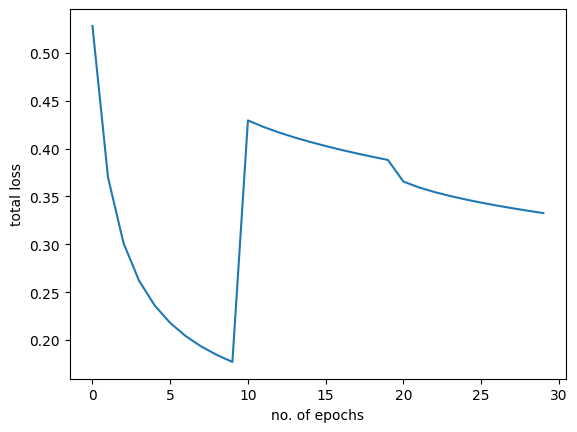

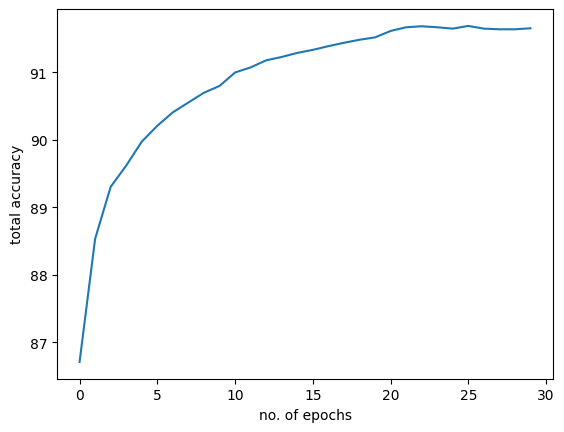

In [12]:
plt.plot(Loss)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.show()
 
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

In [ ]:
print(f"Sample: {train_dataset[:1]}")
print(f"Number of samples: {len(train_dataset)}")

Sample: [(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.000